In [2]:
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pywt
import numpy as np
import Functions.Strand as strand
from reedsolo import RSCodec

In [3]:
fps = ['CCGCCACGTAATATGTCACT', 'AGAAACCATCCAAGGAACCC']
rps = ['TCACGTATAATCCGACTCTC', 'TTGCAGATGAGTAGCCTTGT']

## 二进制、十进制、ascii码转换函数

In [4]:
def BitToDNA(bitStream:str):
    assert len(bitStream) % 2 == 0
    result = ''
    for i in range(len(bitStream) // 2):
        if bitStream[2*i: (i+1)*2] == '00':
            result += 'A'
        elif bitStream[2*i: (i+1)*2] == '01':
            result += 'C'
        elif bitStream[2*i: (i+1)*2] == '10':
            result += 'G'
        else:
            result += 'T'
    return result

def DecToBin(num:int):
    result = []
    while(num // 2 != 0):
        result.append(str(num % 2))
        if(num // 2 !=0):
            num //= 2
    if num == 1:
        result.append("1")
    
    while(len(result) < 8):
        result.append("0")
    result.reverse()  
    return "".join(result)

def DecToBin16U(num:int):
    result = []
    while(num // 2 != 0):
        result.append(str(num % 2))
        if(num // 2 !=0):
            num //= 2
    if num == 1:
        result.append("1")
    
    while(len(result) < 16):
        result.append("0")
    result.reverse()  
    return "".join(result)

def DecToBin16Sign(num:int):
    result = []
    isNegative = False
    if num <0:
        isNegative = True
    if abs(num) > 32767:
        raise ValueError("溢出")
    num = abs(num)
    while(num // 2 != 0):
        result.append(str(num % 2))
        if(num // 2 !=0):
            num //= 2
    if num == 1:
        result.append("1")
    
    while(len(result) < 15):
        result.append("0")
    if isNegative:
        result.append("1")
    else:
        result.append("0")
    result.reverse()  
    return "".join(result)

def BinToDec16Sign(num:str):
    if num[0] == '1':
        return -int(num[1:], 2)
    else:
        return int(num[1:], 2)
    
def BinToDec(num:str):
    return int(num, 2)

def BinToChr(num:str):
    _ascii = int(num, 2)
    return chr(_ascii)
def ChrToBin(ch:str):
    asc = ord(ch)
    return DecToBin(asc)

def BytesToBit(seq):
    result = ""
    for char in seq:
        result += DecToBin(ord(char))
    return result

def BitToBytes(seq):
    result = ""
    assert len(seq) % 8 == 0
    l = len(seq)
    for i in range(int(l/8)):
        result += BinToChr(seq[i*8: (i+1)*8])
    return result


## 系数矩阵转换成字符串及其反变换

In [5]:
def ArrayToBytes(array):
    print(array.shape)
    result = ""
    shape = array.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            result += chr(array[i][j])
    return result
def BytesToArray(seq, hei, wid):
    result = np.zeros((hei,wid ))
    assert(len(seq) == wid * hei)
    
    for i in range(hei):
        for j in range(wid):
            result[i][j] = BinToDec(ChrToBin(seq[i*wid + j]))
    
    return np.uint8(result)

## 游程编码

In [6]:
test_haf_dict = {'ü': '10110011011000',
  '÷': '10110011011001',
  'õ': '0010110101000',
  'ñ': '0010110101001',
  'ò': '0100011001000',
  'ó': '0100011001001',
  'ù': '0101110111100',
  'ý': '0101110111101',
  'ð': '0110100010110',
  'ø': '0110100010111',
  'ë': '1000010001100',
  'ô': '1000010001101',
  'í': '1000010001110',
  'ì': '1000010001111',
  'û': '1001001111110',
  'ö': '1001001111111',
  'å': '1010101001000',
  'þ': '1010101001001',
  'ï': '1011001101101',
  'è': '1011100111000',
  'ç': '1011100111001',
  'ú': '1011100111010',
  'é': '1011100111011',
  'ß': '001011010101',
  '\x83': '010001100101',
  'Ù': '010100000000',
  'î': '010100000001',
  'à': '010100001000',
  'Ý': '010100001001',
  'ã': '010100001110',
  'ê': '010100001111',
  '{': '010111011100',
  'æ': '010111011101',
  'â': '010111011111',
  't': '011010000000',
  'ä': '011010000001',
  'o': '011010001010',
  'Õ': '100100110000',
  'Û': '100100110001',
  'm': '100100111100',
  'q': '100100111101',
  'Þ': '100100111110',
  '×': '100110001110',
  '|': '100110001111',
  'Ü': '101001000110',
  'u': '101001000111',
  '\x89': '101010100101',
  'Ó': '101010100110',
  'á': '101010100111',
  'Ô': '101011001100',
  '\x8b': '101011001101',
  'Ú': '101100001110',
  'Ø': '101100001111',
  'x': '101100110111',
  'i': '00010001110',
  '\x8a': '00010001111',
  '\x8e': '00010110000',
  'j': '00010110001',
  'Ö': '00011011110',
  'h': '00011011111',
  '}': '00101101011',
  'Ñ': '01000000010',
  'g': '01000000011',
  'Ò': '01000110011',
  'Ð': '01010000001',
  'Ï': '01010000101',
  'Î': '01010000110',
  '\x91': '01101000001',
  'Ë': '01101000100',
  'É': '10000100010',
  'Í': '10010011001',
  'v': '10011000110',
  '\x8c': '10100100010',
  'f': '10100101110',
  'Ì': '10100101111',
  '\x8d': '10101100100',
  '\x94': '10101100101',
  'Ç': '10101100111',
  'È': '10110000110',
  'Å': '10110011010',
  'Ê': '10111001111',
  '\x95': '0001000100',
  '\x93': '0001000101',
  'Ä': '0001000110',
  'Æ': '0001011001',
  'Ã': '0001101110',
  '\x92': '0010110100',
  'Á': '0011011100',
  'Â': '0011011101',
  '\x99': '0011101100',
  'À': '0011101101',
  '\x98': '0100000000',
  '\x96': '0100001100',
  '\x97': '0100001101',
  '\x82': '0100011000',
  '¿': '0101000001',
  '\x1f': '0101110100',
  '-': '0101110101',
  '!': '0101110110',
  ')': '0110001110',
  '\x8f': '0110001111',
  ' ': '0110100001',
  '1': '0110100011',
  '#': '1000010000',
  '+': '1000100110',
  ',': '1000100111',
  '½': '1000101000',
  '\x1d': '1000101001',
  'p': '1000101010',
  '%': '1000101011',
  '&': '1000110000',
  '¾': '1000110001',
  '¼': '1000111100',
  '\x9a': '1000111101',
  '$': '1001001101',
  '0': '1001001110',
  '\x1c': '1001100000',
  '/': '1001100001',
  '3': '1001100010',
  '(': '1001100110',
  '\x18': '1001100111',
  'e': '1010010000',
  "'": '1010010100',
  '*': '1010010101',
  '"': '1010010110',
  '.': '1010011010',
  '»': '1010011011',
  '\x17': '1010101000',
  '\x1e': '1010101010',
  '\x16': '1010101011',
  '\x1b': '1010101100',
  'º': '1010101101',
  '\x19': '1010110100',
  '2': '1010110101',
  '¹': '1010110110',
  '4': '1010110111',
  '7': '1011000010',
  '5': '1011001100',
  '\x15': '1011100110',
  '¸': '000101010',
  '\x14': '000101011',
  '\x1a': '000101101',
  '8': '000110110',
  '6': '000111110',
  '9': '000111111',
  '·': '001011011',
  '\x10': '001100010',
  'µ': '001100011',
  '\x13': '001101111',
  '\x90': '001110111',
  '¶': '010000001',
  ':': '010000111',
  ';': '010001101',
  '\x0f': '010111110',
  '´': '010111111',
  '\x11': '011000100',
  '=': '011000101',
  '<': '011000110',
  'd': '100001001',
  '\x12': '100010000',
  '@': '100010001',
  '?': '100010010',
  '³': '100011001',
  'n': '100011111',
  'c': '100110010',
  '\x0e': '101000100',
  '²': '101000101',
  '>': '101001001',
  'A': '101001100',
  '±': '101010111',
  '\r': '101011000',
  's': '101100000',
  '~': '101100010',
  'r': '101100011',
  '°': '101100111',
  '¯': '101110010',
  'B': '101111100',
  'w': '101111101',
  'a': '101111110',
  'C': '101111111',
  '\x0c': '00010000',
  'D': '00010100',
  '\x0b': '00010111',
  'b': '00011010',
  '®': '00011100',
  'E': '00011101',
  '\\': '00011110',
  '\t': '00101100',
  '\xad': '00110000',
  '\n': '00110110',
  '`': '00111010',
  ']': '00111100',
  '¬': '00111101',
  'F': '01000001',
  '\x08': '01000010',
  '\x9f': '01000100',
  '\xa0': '01000101',
  '^': '01000111',
  '\x9e': '01010001',
  'G': '01011100',
  'H': '01011110',
  '_': '01100000',
  '«': '01100001',
  '\x7f': '01101001',
  '[': '01101010',
  'ª': '01101011',
  '\x9d': '01101100',
  '\x07': '01101101',
  '\x9b': '01101110',
  'I': '01101111',
  '©': '10000101',
  '¢': '10001011',
  '¡': '10001101',
  '£': '10001110',
  'J': '10010010',
  '¤': '10010100',
  'K': '10010101',
  '\x85': '10010110',
  '\x9c': '10010111',
  '¨': '10100011',
  '¥': '10100111',
  'L': '10101000',
  '§': '10101001',
  '¦': '10110010',
  'M': '10111000',
  '\x06': '0001001',
  'Q': '0001100',
  'N': '0010100',
  'O': '0010101',
  'R': '0010111',
  'P': '0011001',
  '\x05': '0011010',
  '\x04': '0011100',
  'S': '0011111',
  'T': '0100100',
  '\x80': '0100101',
  'U': '0101001',
  'V': '0110010',
  'W': '0110011',
  '\x03': '1000011',
  'X': '1001000',
  'Z': '1001101',
  'Y': '1010000',
  '\x02': '1010111',
  'k': '1011101',
  'z': '1011110',
  '\x88': '010011',
  '\x86': '010101',
  '\x84': '010110',
  '\x87': '100000',
  '\x01': '100111',
  'l': '101101',
  '\x81': '00100',
  'ÿ': '0000',
  'y': '0111',
  '\x00': '11'}

In [25]:
def RunLengthEncode(seq:str):
    # 游程编码  结构化格式，两字节为一组，第一个字节为个数，最大256（0000 0000 表示1） 第二个字节为数据
    result = ""
    seqq = ""
    now = seq[0]
    count = 1
    for i in range(1, len(seq)):
        if now == seq[i]:
            count += 1
            
            if count == 256 and i != len(seq)-1:
                result += DecToBin(count-1) + ChrToBin(now)
                seqq += BinToChr(DecToBin(count-1)) + now
                now = seq[i+1]
                count = 0
                continue
            elif count == 256 and i == len(seq)-1:
                result += DecToBin(count-1) + ChrToBin(seq[i])
                seqq += BinToChr(DecToBin(count-1)) + seq[i]
                break
        else: 
            result += DecToBin(count-1) + ChrToBin(now)
            seqq += BinToChr(DecToBin(count-1)) + now
            now = seq[i]
            count = 1
        if i == len(seq)-1: 
            result += DecToBin(count-1) + ChrToBin(seq[i])
            seqq += BinToChr(DecToBin(count-1)) + seq[i]
    print("RunLength--原始比特长度：" + str(len(seq) * 8) + "  编码后比特长度：" + str(len(result)) + "  压缩率：" + str((len(seq) * 8 - len(result)) / (len(seq) * 8)))
    return seqq, result

def RunLengthDecode(seq:str):
    # 游程解码
    blocks_count = len(seq) // 16
    result = ""
    for i in range(blocks_count):
        content = seq[16*i : 16*(i+1)]
        #print(content)
        count = BinToDec(content[:8]) + 1
        char = BinToChr(content[8:])
        for j in range(count):
            result += char
    return result

## 哈夫曼编码

In [6]:
# coding:utf-8

#Tree-Node Type
class Node:
    def __init__(self,freq):
        self.left = None
        self.right = None
        self.father = None
        self.freq = freq
    def isLeft(self):
        return self.father.left == self
#create nodes创建叶子节点
def createNodes(freqs):
    return [Node(freq) for freq in freqs]

#create Huffman-Tree创建Huffman树
def createHuffmanTree(nodes):
    queue = nodes[:]
    while len(queue) > 1:
        queue.sort(key=lambda item:item.freq)
        node_left = queue.pop(0)
        node_right = queue.pop(0)
        node_father = Node(node_left.freq + node_right.freq)
        node_father.left = node_left
        node_father.right = node_right
        node_left.father = node_father
        node_right.father = node_father
        queue.append(node_father)
    queue[0].father = None
    return queue[0]
#Huffman编码
def huffmanEncoding(nodes,root):
    codes = [''] * len(nodes)
    for i in range(len(nodes)):
        node_tmp = nodes[i]
        while node_tmp != root:
            if node_tmp.isLeft():
                codes[i] = '0' + codes[i]
            else:
                codes[i] = '1' + codes[i]
            node_tmp = node_tmp.father
    return codes

# 解压缩huffman文件
def decode_huffman(input_string,  char_store, freq_store):
    #input_string 哈夫曼编码
    #char_store 字符集合 
    #freq_store 字符转编码01序列
    encode = ''
    decode = ''
    bitStream = ""
    for index in range(len(input_string)):
        encode = encode + input_string[index]
        for item in zip(char_store, freq_store):
            if encode == item[1]:
                decode = decode + item[0]
                bitStream += ChrToBin(item[0])
                encode = ''
    return decode, bitStream;           

#获取Huffman编码
def getHuffmanCode(string):   
    dict1 ={}
    for  i in string:
        if i in dict1.keys():
            dict1[i] += 1
        else :
            dict1[i] = 1 
    #将字符根据频次排序
    chars_freqs  = sorted(dict1.items(), key = lambda kv:(kv[1], kv[0]))
    #创建huffman节点树
    nodes = createNodes([item[1] for item in chars_freqs])
    root = createHuffmanTree(nodes)
    #每个字符的Huffman编码
    codes = huffmanEncoding(nodes,root)
    #print codes
    dict2 = {}
    for item in zip(chars_freqs,codes):
        #print 'Character:%s freq:%-2d   encoding: %s' % (item[0][0],item[0][1],item[1])
        dict2[item[0][0]] = item[1]
    _str = ''
    for v in string:
        _str += dict2[v]
    print("Huffman--原始比特长度：" + str(len(string) * 8) + "  编码后比特长度：" + str(len(_str)) + "  压缩率：" + str((len(string) * 8 - len(_str)) / (len(string) * 8)))
    return [_str,dict2]

def encode_huffman(string, huffman_dict):

    _str = ''
    for v in string:
        _str += huffman_dict[v]
    print("Huffman--原始比特长度：" + str(len(string) * 8) + "  编码后比特长度：" + str(len(_str)) + "  压缩率：" + str((len(string) * 8 - len(_str)) / (len(string) * 8)))
    return [_str,huffman_dict]


# 解码器 Decoder_CoeDataFrame

In [1]:
class Decoder_CoeDataFrame:
    def __init__(self):
        self.coeChannels = None
        self.level = 0
        self.shape = None

        
    def Decode(self, encode_data, huf_dict, isGrayImg=False):
        if huf_dict == None:
            raise ValueError("未提供哈夫曼解码表")
        self.level = (len(encode_data) - 1) // 9
        if isGrayImg:
            self.level = (len(encode_data)-1) // 3
        
        self.Ychannel = [[None for i in range(3)] for _ in range(self.level)]
        self.Ychannel.insert(0, None)                # [None(直流分量）, []第一级交流分量, []...]
        print(self.Ychannel)
        
        self.Cbchannel = [[None for i in range(3)] for _ in range(self.level)]
        self.Cbchannel.insert(0, None)                # [None(直流分量）, []第一级交流分量, []...]
        
        self.Crchannel = [[None for i in range(3)] for _ in range(self.level)]
        self.Crchannel.insert(0, None)                # [None(直流分量）, []第一级交流分量, []...]
        
        self.coeChannels = CoeChannels(self.level, isGrayImg)
        for data in encode_data:
            df = CoeDataFrame().CreateDecoder(data, huf_dict)
            print(df.coe_level, df.coe_where)
            if df.channel_index == 0:  # Y通道
                if df.coe_where == 0:  # LL
                    self.Ychannel[0] = df.coeItem
                else:
                    self.Ychannel[df.coe_level][df.coe_where-1] = df.coeItem
            if not isGrayImg:
                if df.channel_index == 1:  # Cb
                    if df.coe_where == 0:  # LL
                        self.Cbchannel[0] = df.coeItem
                    else:
                        self.Cbchannel[df.coe_level][df.coe_where-1] = df.coeItem
                elif df.channel_index == 2:  # Cb
                    if df.coe_where == 0:  # LL
                        self.Crchannel[0] = df.coeItem
                    else:
                        self.Crchannel[df.coe_level][df.coe_where-1] = df.coeItem
            self.coeChannels.Ychannel = self.Ychannel
            self.coeChannels.Cbchannel = self.Cbchannel
            self.coeChannels.Crchannel = self.Crchannel
        return self
        

# 封装系数帧 CoeDataFrame

In [28]:
# [7bit 描述头 [D6D5 | 00 R 01 G 10 B, D4D3D2 000-111 小波级别, D1D0 00 LL 01 LH 10 HL 11 HH] ] 
# [16bit行数]  [16bit列数] [16bit int16 maxV]  [16bit int16 minV]  [2bit compress method( 01 游程 10 haffman 11 二者兼具)]  [1bit payload bit数是奇数还是偶数]
class CoeDataFrame:
    def __init__(self):
        #               系数元素对象，通道索引， 级数索引， 分量索引
        self.b_desc = ""
        self.b_width = ""
        self.b_height = ""
        self.b_maxV = ""
        self.b_minV = ""
        self.b_ifOdd = ""
        self.b_payload = ""
        self.b_compressMethods = ""
        
        self.coeItem = None
        self.channel_index = None   # 0-Y  1-Cb   2-Cr
        self.coe_level = None   # 小波变换级数
        self.coe_where = None   # 系数位置 0 LL 1 LH 2 HL 3 HH
        self.width = None
        self.height = None
        self.compressMethod = None  # 0 无 1 游程 2 huffman 3 游程＋huffman
        self.is_odd = None  # payload 有效bit数是否为奇数
        
        
        self.huffman_dict = None
    
    def CreateEncoder(self, coeItem, channelIdx, levelIdx, coe_whereIdx, huffman_dict = test_haf_dict):
        self.coeItem = coeItem
        self.channel_index = channelIdx   # 0-Y  1-Cb   2-Cr
        self.coe_level = levelIdx   # 小波变换级数
        self.coe_where = coe_whereIdx   # 系数位置 0 LL 1 LH 2 HL 3 HH
        self.width = coeItem.quantArray.shape[1]
        self.height = coeItem.quantArray.shape[0]
        self.huffman_dict = huffman_dict
        self.compressMethod = 0  # 0 无 1 游程 2 huffman 3 游程＋huffman
        # 决定采用何种压缩方式
        array_byte = ArrayToBytes(self.coeItem.quantArray)
        ori_len = len(array_byte)
        enc = RunLengthEncode(array_byte)
        enc_bit = enc[1]
        enc_len = len(enc[0])
        
        if ori_len > enc_len:
            # 原始序列长度大于压缩后的序列长度
            self.compressMethod += 1  # 游程
            array_byte = enc[0]
            ori_len = len(array_byte)
            
        # 判断是否采用huffman编码
        enc = encode_huffman(array_byte, self.huffman_dict)
        enc_bit = enc[0]
        enc_len = len(enc[0])
        if ori_len * 8 > enc_len:
            # 如果原始序列长度大于压缩后的序列长度
            self.compressMethod += 2 # 哈夫曼
            
        self.is_odd = False  # payload 有效bit数是否为奇数
        self._encode_data_to_b()
        return self
    
    def CreateDecoder(self, seq, huffman_dict = test_haf_dict):
        header = seq[:74]
        self.b_desc = header[:7]
        self.b_height = header[7:23]
        self.b_width = header[23:39]
        self.b_maxV = header[39:55]
        self.b_minV = header[55:71]
        self.b_compressMethods = header[71:73]
        self.b_ifOdd = header[73:74]
        self.b_payload = seq[74:]
        self.huffman_dict = huffman_dict
        self._decode_b_to_data()
        return self
        
    def _decode_b_to_data(self):
        self.channel_index = BinToDec(self.b_desc[:2])
        self.coe_level = BinToDec(self.b_desc[2:5])
        self.coe_where = BinToDec(self.b_desc[5:7])
        self.height = BinToDec(self.b_height)
        self.width = BinToDec(self.b_width)
        self.maxV = BinToDec16Sign(self.b_maxV)
        self.minV = BinToDec16Sign(self.b_minV)
        self.compressMethod = BinToDec(self.b_compressMethods)
        is_odd = BinToDec(self.b_ifOdd)
        if is_odd == 1:
            self.is_odd = True
            self.b_payload = self.b_payload[:-1]
            print("发现有效bit为奇数，已经自动丢弃最后一个bit，有效bit长度：" + str(len(self.b_payload)))
        else:
            self.is_odd = False
        
        if self.compressMethod == 0:
            self.coeItem = CoefficientItem().decode_quantArray(BytesToArray(BitToBytes(self.b_payload),  self.height, self.width), self.maxV, self.minV)
            print("不采用任何算法解码")
        elif self.compressMethod == 1:
            self.coeItem = CoefficientItem().decode_quantArray(BytesToArray(RunLengthDecode(self.b_payload),  self.height, self.width), self.maxV, self.minV)
            print("采用游程算法解码")
        elif self.compressMethod == 2:
            self.coeItem = CoefficientItem().decode_quantArray(BytesToArray(decode_huffman(self.b_payload, self.huffman_dict.keys(), self.huffman_dict.values())[0], self.height, self.width), self.maxV, self.minV)
            print("采用哈夫曼算法解码")
        elif self.compressMethod == 3:
            temp = decode_huffman(self.b_payload, self.huffman_dict.keys(), self.huffman_dict.values())[1]
            self.coeItem = CoefficientItem().decode_quantArray(BytesToArray(RunLengthDecode(temp), self.height, self.width), self.maxV, self.minV)
            print("采用游程+哈夫曼算法解码")
        
    def _encode_data_to_b(self):
        self.b_desc = DecToBin(self.channel_index)[-2:] + DecToBin(self.coe_level)[-3:] + DecToBin(self.coe_where)[-2:]
        self.b_height = DecToBin16U(self.height)
        self.b_width = DecToBin16U(self.width)
        self.b_maxV = DecToBin16Sign(self.coeItem.maxV)
        self.b_minV = DecToBin16Sign(self.coeItem.minV)
        self.b_compressMethods = DecToBin(self.compressMethod)[-2:]
        
        if self.compressMethod == 0:
            self.b_payload = BytesToBit(ArrayToBytes(self.coeItem.quantArray))
            print("不采用任何压缩编码")
        elif self.compressMethod == 1:
            self.b_payload = BytesToBit(RunLengthEncode(ArrayToBytes(self.coeItem.quantArray))[1])
            print("采用游程压缩编码")
        elif self.compressMethod == 2:
            self.b_payload = encode_huffman(ArrayToBytes(self.coeItem.quantArray), self.huffman_dict)[0]
            print("采用哈夫曼压缩编码")
        elif self.compressMethod == 3:
            temp = RunLengthEncode(ArrayToBytes(self.coeItem.quantArray))[0]
            self.b_payload = encode_huffman(temp, self.huffman_dict)[0]
            print("采用游程+哈夫曼压缩编码")
        if len(self.b_payload) % 2 == 1:
            self.b_ifOdd = "1"
            self.b_payload += "0"
            print("发现有效bit为奇数，已经自动在最后一个bit后补0，总长度："+ str(len(self.b_payload)))
        else:
            self.b_ifOdd = "0"
        
    def get_data_stream(self):
        return self.b_desc + self.b_height + self.b_width + self.b_maxV + self.b_minV + self.b_compressMethods + self.b_ifOdd + self.b_payload
        
        

In [29]:
a = BytesToBit(ArrayToBytes(dna.coeChannels.Ychannel[0].quantArray))
b = BitToBytes(a)

NameError: name 'dna' is not defined

In [30]:
dna = DNAImage(Image.open("a.jpg"))
t = dna.DWT(6)
# t.coeChannels.ConstraintCoeItemsToZero(6)
enc = t.coeChannels.encode(3, 6)
for data in enc:
    decoder = CoeDataFrame().CreateDecoder(data, t.coeChannels.huf_dict)
    print(decoder.coeItem.quantArray.shape)
# encoder = CoeDataFrame()
# array = dna.coeChannels.Cbchannel[1][2]
# data = encoder.CreateEncoder(array, 0, 0, 0).get_data_stream()
# decoder = CoeDataFrame()
# decoder.CreateDecoder(data).coeItem.quantArray
# print(decoder.coeItem.quantArray)
# print(array.quantArray)

FileNotFoundError: [Errno 2] No such file or directory: 'a.jpg'

# 封装DNA序列帧 DNAFrameGroup

In [58]:
# 针对每一个CoeDataFrame的一组DNAFrame

class DNAFrameGroup:
    def __init__(self):
        self.rFV = 'TTACTGACCCTGTCCCGAGG'  # 特征向量下游引物
        self.bp_payload = ''
        self.fp1 = ''
        self.rp1 = ''
        self.fp2 = ''
        self.rp2 = ''
        self.coeDataFrame = None
        self.whichFile = 0
        self.final_payload_length = 0  # 最后一帧DNAFrame有效载荷长度
        self.DNAFrame_count = 0  # 对于一帧CoeDataFrame所包含的DNAFrame数量
        self.isPreview = False
        self.vectorSeq = ""
        self.max_payload_length = 326
        self.dna_seq_group = []  # 对于一帧CoeDataFrame所包含的全部DNA序列
        self.RSCodeCount = 4
        self.last_encoder_address_count = 0
        
        
    def CreateEncoder(self, bit_stream: str, fp1, fp2, rp2, rp1, file_index:int, isPreview, vectorSeq="", RSCodeCount = 0):
        #                    字节流             两层上下游引物       文件索引     是否是摘要序列   特征向量    RS码字节数             上一个编码器地址计数
        self.fp1 = fp1
        self.fp2 = fp2
        self.rp1 = rp1
        self.rp2 = rp2
        self.whichFile = file_index
        self.isPreview = isPreview
        self.vectorSeq = vectorSeq
        self.RSCodeCount = RSCodeCount
        self.dna_seq_group = []
        if isPreview:
            self.max_payload_length = 344 - 4 * RSCodeCount
        else:
            self.max_payload_length = 432 - 4 * RSCodeCount 
        
        segment_count = len(bit_stream) // 2 // self.max_payload_length
        print("需要分割的段数为：", segment_count+1)
        if segment_count+1 > 256:
            raise IndexError("分割段数超过256，无法在4个碱基的地址码下完成分割")
        bit_seqs = []
        dna_seqs = []
        # 将原始bit流分割成不同的段数后添加到列表中
        for i in range(segment_count):
            bit_seqs.append(bit_stream[i*self.max_payload_length*2 : (i+1)*self.max_payload_length*2])
        bit_seqs.append(bit_stream[segment_count * self.max_payload_length * 2:])
        # 纠错码添加
        
        for i in range(len(bit_seqs)):
            #编码
            if len(bit_seqs[-1]) % 8 != 0:
                bit_seqs[-1] += '0' * (8 - len(bit_seqs[-1]) % 8)
            ecc=RSCodec(4)#纠错码字长度，可纠正n/2个误读
            bit_header = DecToBin(self.whichFile)[-4:] + DecToBin(self.last_encoder_address_count + i)
            print("self.last_encoder_address_count + i", self.last_encoder_address_count + i)
            #print("原始比特长度", len(bit_seqs[i]))
            # print("原始比特流", BytesToBit(BitToBytes(bit_seqs[i])))
            byte_msg=ecc.encode(b''.join(ord(ch).to_bytes(1, byteorder='little', signed=False) for ch in BitToBytes(bit_seqs[i])))
            #转换为二进制
            #print('加纠错码后比特长度：', len(byte_msg)*8)
            binary_code=''.join(format(x,'08b') for x in byte_msg)
            # print('加纠错码后比特流', binary_code)
            prepare_seq = bit_header + binary_code

            bp_header_payload = BitToDNA(prepare_seq)
            
            fpl = []
            rpl = []
            if self.isPreview:
                # 如果是预览文件序列
                fpl.append(self.vectorSeq)
            fpl.append(self.fp1)
            fpl.append(self.fp2)
            rpl.append(self.rp2)
            rpl.append(self.rp1)
            if self.isPreview:
                rpl.append(self.rFV)
            bp_this_seq = strand.assemble_primer_and_payload(fpl, bp_header_payload, rpl)
            #print(bp_this_seq[0])
            print('[', i+1, ']', '序列碱基数', bp_this_seq[0].__len__())
            self.dna_seq_group.append(bp_this_seq[0])
            
            #纠错
            #先转换为bytearray形式
            bytes_msg=bytes(int(binary_code[j:j+8],2) for j in range(0,len(binary_code),8))
            array_msg=bytearray(bytes_msg)
            #再纠错
            data=ecc.decode(array_msg)
            msg=data[0]
            result = ''.join(DecToBin(num) for num in msg)
            assert bit_seqs[i] == result
            
        self.last_encoder_address_count += segment_count + 1
        return self

# [TODO]  DNA序列帧解码器 Decoder_DNAFrame  

In [14]:
class Decoder_DNAFrame:
    def __init__(self):
        self.bp_seq = ''

# 小波系数管理类、图像类

In [59]:
# 小波系数管理类
class CoeChannels:
    def __init__(self, level, isGrayImg=False):
        self.level = level 
        
        self.Ychannel = [[] for _ in range(level)]
        self.Ychannel.insert(0, None)                # [None(直流分量）, []第一级交流分量, []...]
        
        self.Cbchannel = [[] for _ in range(level)]
        self.Cbchannel.insert(0, None)
        
        self.Crchannel = [[] for _ in range(level)]
        self.Crchannel.insert(0, None)
        
        self.yIDWT = [[], ()]
        self.cbIDWT = [[], ()]
        self.crIDWT = [[], ()]
        
        self.huf_dict = None   # 哈夫曼编码表，需要在使用Decode_DNAImage时传递此解码表
        self.isGrayImg = isGrayImg
        
    def SetYchannel(self, coes):
        
        self.Ychannel = [[] for _ in range(self.level)]
        self.Ychannel.insert(0, None) 
        
        self.Ychannel[0] = CoefficientItem(coes[0])
        for i in range(self.level):
            for j in range(3):
                coeItem = CoefficientItem(coes[i+1][j])
                self.Ychannel[i+1].append(coeItem)
                print("Y:", coes[i+1][j].shape)
                
    def SetCbchannel(self, coes):
        
        self.Cbchannel = [[] for _ in range(self.level)]
        self.Cbchannel.insert(0, None) 
        
        self.Cbchannel[0] = CoefficientItem(coes[0])
        for i in range(self.level):
            for j in range(3):
                coeItem = CoefficientItem(coes[i+1][j])
                self.Cbchannel[i+1].append(coeItem)
                print("Cb:", coes[i+1][j].shape)
                
    def SetCrchannel(self, coes):
        
        self.Crchannel = [[] for _ in range(self.level)]
        self.Crchannel.insert(0, None) 
        
        self.Crchannel[0] = CoefficientItem(coes[0])
        for i in range(self.level):
            for j in range(3):
                coeItem = CoefficientItem(coes[i+1][j])
                self.Crchannel[i+1].append(coeItem)
                print("Cr:", coes[i+1][j].shape)
                
    def AssembleAllChannelsForIDWT(self):
        # 重新组合全部通道的系数，为了进行离散小波逆变换
        if self.level != 1:
            raise ValueError("此函数仅支持组合级数为1的小波变换系数")
        self.yIDWT = [self.Ychannel[0].IquantArray, (self.Ychannel[1][0].IquantArray,
                                                    self.Ychannel[1][1].IquantArray,
                                                    self.Ychannel[1][2].IquantArray,)]
        
        self.cbIDWT = [self.Cbchannel[0].IquantArray, (self.Cbchannel[1][0].IquantArray,
                                                    self.Cbchannel[1][1].IquantArray,
                                                    self.Cbchannel[1][2].IquantArray,)]
        
        self.crIDWT = [self.Crchannel[0].IquantArray, (self.Crchannel[1][0].IquantArray,
                                                    self.Crchannel[1][1].IquantArray,
                                                    self.Crchannel[1][2].IquantArray,)]
        
        return self
    
    # 将小波系数按照最大最小值除以缩放因子将对应范围内的小波系数变为0
    def ConstraintCoeItemsToZero(self, factor):
        
        if factor == 0:
            self.RecaculateAllItems()
            return
        for i in range(self.level):
            for j in range(3):
                ff = 1
                if j == 2:
                    ff = 2
                t = self.Ychannel[i+1][j].originalArray
                a = t < t.max() / (factor // (i + 1) // ff + 1)
                b = t > t.min() / (factor // (i + 1) // ff + 1)
                t[a & b] = 0
                self.Ychannel[i+1][j].originalArray = t
                
                if self.isGrayImg:
                    self.RecaculateAllItems()
                    return
                t = self.Cbchannel[i+1][j].originalArray
                a = t < t.max() / (factor // (i + 1) // ff + 1)
                b = t > t.min() / (factor // (i + 1) // ff + 1)
                t[a & b] = 0
                self.Cbchannel[i+1][j].originalArray = t
                t = self.Crchannel[i+1][j].originalArray
                a = t < t.max() / (factor // (i + 1) // ff + 1)
                b = t > t.min() / (factor // (i + 1) // ff + 1)
                t[a & b] = 0
                self.Crchannel[i+1][j].originalArray = t
                
        self.RecaculateAllItems()
    
    def RecaculateAllItems(self):
        if self.isGrayImg:
            self.Ychannel[0].RecalculateAllArray()
            for i in range(self.level):
                for j in range(3):
                    self.Ychannel[i+1][j].RecalculateAllArray()
                    return
            
        self.Ychannel[0].RecalculateAllArray()
        self.Cbchannel[0].RecalculateAllArray()
        self.Crchannel[0].RecalculateAllArray()
        for i in range(self.level):
            for j in range(3):
                self.Ychannel[i+1][j].RecalculateAllArray()
                self.Cbchannel[i+1][j].RecalculateAllArray()
                self.Crchannel[i+1][j].RecalculateAllArray()
    
    def AssembleAndCalulateIDWT_2levels(self, bias):
        result = []
        if not self.isGrayImg:
            
            pic = np.dstack((self.Ychannel[0].IquantArray, 
                     self.Cbchannel[0].IquantArray, 
                     self.Crchannel[0].IquantArray )) + bias

            temp = pic / pic.max() * 255
            temp[temp > 255] = 255
            pic = np.uint8(temp)
            img0 = Image.fromarray(pic, mode="RGB").convert("RGB")
            result.append(img0)

            iy = self.Ychannel[0].IquantArray
            ib = self.Cbchannel[0].IquantArray
            ir = self.Crchannel[0].IquantArray

            for i in range(self.level):

                self.yIDWT = [iy, (self.Ychannel[i+1][0].IquantArray,
                                                            self.Ychannel[i+1][1].IquantArray,
                                                            self.Ychannel[i+1][2].IquantArray,)]

                self.cbIDWT = [ib, (self.Cbchannel[i+1][0].IquantArray,
                                                            self.Cbchannel[i+1][1].IquantArray,
                                                            self.Cbchannel[i+1][2].IquantArray,)]

                self.crIDWT = [ir, (self.Crchannel[i+1][0].IquantArray,
                                                            self.Crchannel[i+1][1].IquantArray,
                                                            self.Crchannel[i+1][2].IquantArray,)]
                iy = pywt.waverec2(self.yIDWT, "db1", mode="periodization")
                ib = pywt.waverec2(self.cbIDWT, "db1", mode="periodization")
                ir = pywt.waverec2(self.crIDWT, "db1", mode="periodization")

                print(iy.min(), ib.min(), ir.min())
                print(iy.max(), ib.max(), ir.max())

                pic = np.dstack(((iy), (ib), (ir))) + bias * (self.level - i)

                temp = pic / pic.max() * 255
                temp[temp > 255] = 255
                pic = np.uint8(temp)

                # pic = np.dstack(((iy), (ib), (ir))) + bias
                # pic = np.uint8(pic)

                img1 = Image.fromarray(pic, mode="RGB").convert("RGB")

                result.append(img1)
        
        else:
            pic = self.Ychannel[0].IquantArray + bias

            temp = pic / pic.max() * 255
            temp[temp > 255] = 255
            pic = np.uint8(temp)
            img0 = Image.fromarray(pic, mode="L")
            result.append(img0)

            iy = self.Ychannel[0].IquantArray

            for i in range(self.level):

                self.yIDWT = [iy, (self.Ychannel[i+1][0].IquantArray,
                                                            self.Ychannel[i+1][1].IquantArray,
                                                            self.Ychannel[i+1][2].IquantArray,)]

                iy = pywt.waverec2(self.yIDWT, "db1", mode="periodization")

                pic = iy + bias * (self.level - i)

                temp = pic / pic.max() * 255
                temp[temp > 255] = 255
                pic = np.uint8(temp)

                img1 = Image.fromarray(pic, mode="L")

                result.append(img1)
   
        return result

    def encode(self, level=0, factor=20):
        #             进行编码的小波级数  缩放因子
        if level == 0:
            level = self.level
        result = []
        haf_data = ""
        self.ConstraintCoeItemsToZero(factor)
        # 先对高频分量进行游程编码后作为哈夫曼编码的原始语料
        haf_data += ArrayToBytes(self.Ychannel[0].quantArray)
        if not self.isGrayImg:
            haf_data += ArrayToBytes(self.Cbchannel[0].quantArray)
            haf_data += ArrayToBytes(self.Crchannel[0].quantArray)
        for i in range(level):
            for j in range(3):
                array = ArrayToBytes(self.Ychannel[i+1][j].quantArray)
                data = array
                ori_len = len(array) * 8
                enc_data = RunLengthEncode(array)[0]
                if ori_len > len(enc_data):
                    data = enc_data
                haf_data += data
                
                if not self.isGrayImg:
                    array = ArrayToBytes(self.Cbchannel[i+1][j].quantArray)
                    data = array
                    ori_len = len(array) * 8
                    enc_data = RunLengthEncode(array)[0]
                    if ori_len > len(enc_data):
                        data = enc_data
                    haf_data += data

                    array = ArrayToBytes(self.Crchannel[i+1][j].quantArray)
                    data = array
                    ori_len = len(array) * 8
                    enc_data = RunLengthEncode(array)[0]
                    if ori_len > len(enc_data):
                        data = enc_data
                    haf_data += data
                
        huf_dict = getHuffmanCode(haf_data)[1]
        
        result.append(
            CoeDataFrame().CreateEncoder(self.Ychannel[0], 0, 0, 0, huf_dict).get_data_stream()
        )
        if not self.isGrayImg:
            result.append(
                CoeDataFrame().CreateEncoder(self.Cbchannel[0], 1, 0, 0, huf_dict).get_data_stream()
            )
            result.append(
                CoeDataFrame().CreateEncoder(self.Crchannel[0], 2, 0, 0, huf_dict).get_data_stream()
            )
        for i in range(level):
            for j in range(3):
                result.append(
                    CoeDataFrame().CreateEncoder(self.Ychannel[i+1][j], 0, i+1, j+1, huf_dict).get_data_stream()
                )
                if not self.isGrayImg:
                    result.append(
                        CoeDataFrame().CreateEncoder(self.Cbchannel[i+1][j], 1, i+1, j+1, huf_dict).get_data_stream()
                    )
                    result.append(
                        CoeDataFrame().CreateEncoder(self.Crchannel[i+1][j], 2, i+1, j+1, huf_dict).get_data_stream()
                    )
        self.huf_dict = huf_dict
        
        ori_cost = self.Ychannel[level][2].quantArray.shape[0] * self.Ychannel[level][2].quantArray.shape[1] * 12 * 2
        now_len = 0
        for i in range(len(result)):
            now_len += len(result[i])
            print(len(result[i]))
        now_cost = now_len / 4
        print("----------------")
        print("原始成本：{}元".format(ori_cost))
        print("压缩后成本：{}元".format(now_cost))
        print("成本压缩率：{}%".format((ori_cost - now_cost) / ori_cost*100))
        print("----------------")
        return result

# 小波系数类
class CoefficientItem:
    def __init__(self, originalArray=np.ones((2, 2))):
        self.maxV = 0
        self.minV = 0
        self.delta = 0
        self.originalArray = None
        self.quantArray = None
        self.IquantArray = None
        
        self.originalArray = originalArray
        self.maxV = int(originalArray.max())
        self.minV = int(originalArray.min())
        self.delta = (self.maxV - self.minV) / 255
        t = (self.originalArray - self.minV) / self.delta
        t[t > 255] = 255
        self.quantArray = np.uint8(t)
        self.IquantArray = self.quantArray * self.delta + 1*self.minV
        
    def decode_quantArray(self, quantArray, maxV, minV):
        self.quantArray = quantArray
        self.maxV = maxV
        self.minV = minV
        self.delta = (self.maxV - self.minV) / 255
        self.IquantArray = self.quantArray * self.delta + self.minV
        return self
        
    def RecalculateIquantArray(self):
        self.IquantArray = self.quantArray * self.delta + self.minV
        
    def RecalculateAllArray(self):
        self.maxV = int(self.originalArray.max())
        self.minV = int(self.originalArray.min())
        self.delta = (self.maxV - self.minV) / 255
        
        t = (self.originalArray - self.minV) / self.delta
        t[t > 255] = 255
        self.quantArray = np.uint8(t)
        self.IquantArray = self.quantArray * self.delta + self.minV

In [60]:
# 图像类
class DNAImage:
    def __init__(self, image:Image):
        self.image = image
        self.level = 0
        self.shape = None
        self.RGB_array = None          # RGB通道图像矩阵 维度（x, y, 3)
        self.RGB_img = None
        self.YCbCr_array = None
        self.YCbCr_img = None
        
        self.coeChannels = None # 存储小波变换系数的三通道列表 【Y， Cb， Cr】

        self.info_init()
        
    def info_init(self):
        self.RGB_img = self.image.convert("YCbCr")#.resize((96, 54))
        self.YCbCr_img = self.image.convert("RGB")#.resize((16*20, 9*20))
        self.gray_img = self.image.convert("L").resize((55, 36))
        self.RGB_array = np.array(self.RGB_img)
        self.YCbCr_array = np.array(self.YCbCr_img)
        self.gray_array = np.array(self.gray_img)
        
        # DC平移
        self.YCbCr_array = np.int16(self.YCbCr_array)
        #self.YCbCr_array -= 128

        
        print(self.YCbCr_array.shape)
        return self
        
    def DWT(self, level, isGrayImg=False):
        self.level = level
        
        if not isGrayImg:
            self.coeChannels = CoeChannels(level)
            Yc = pywt.wavedec2(self.YCbCr_array[:,:,0], 'db1', mode="periodization", level=level)
            Cbc = pywt.wavedec2(self.YCbCr_array[:,:,1], 'db1', mode="periodization", level=level)
            Crc = pywt.wavedec2(self.YCbCr_array[:,:,2], 'db1', mode="periodization", level=level)

            self.coeChannels.SetYchannel(Yc)
            self.coeChannels.SetCbchannel(Cbc)
            self.coeChannels.SetCrchannel(Crc)
        else:
            self.coeChannels = CoeChannels(level, True)
            self.coeChannels.SetYchannel(pywt.wavedec2(self.gray_array, 'db1', mode="periodization", level=level))
        
        
        return self
    
    def show(self):
        plt.imshow(self.RGB_array/255)

# 小波逆变换之后进行反向DC偏移恢复原始图像

In [17]:
dna = DNAImage(Image.open("4.jpg"))
t = dna.DWT(1).coeChannels.AssembleAllChannelsForIDWT()
print(t.Ychannel[1][2].quantArray.flat)
#print(np.bincount(t.Ychannel[1][2].quantArray.flat))
iy = pywt.waverec2(t.yIDWT, "db1", mode="periodization")
ib = pywt.waverec2(t.cbIDWT, "db1", mode="periodization")
ir = pywt.waverec2(t.crIDWT, "db1", mode="periodization")

pic = np.dstack((np.uint8(iy), np.uint8(ib), np.uint8(ir)))
img = Image.fromarray(pic, mode="YCbCr").convert("RGB")
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: '4.jpg'

NameError: name 'dna' is not defined

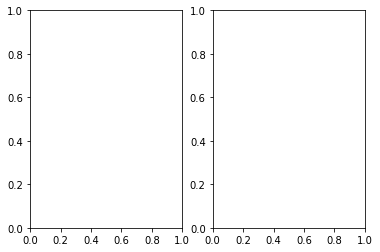

In [18]:
f, ax = plt.subplots(1, 2)
ax[0].imshow(dna.RGB_array)
ax[1].imshow(img)
f.savefig("www.png")

# YCbCr空间的多级分辨率预览操作

In [19]:
bias = 7200
pic = np.dstack((dna.coeChannels.Ychannel[0].IquantArray, 
                 dna.coeChannels.Cbchannel[0].IquantArray, 
                 dna.coeChannels.Crchannel[0].IquantArray )) + bias

print(pic.min())
pic = np.uint8(pic / pic.max() * 255)
img = Image.fromarray(pic, mode="YCbCr").convert("RGB")
plt.imshow(np.array(img))
# plt.imshow(dna.YCbCr_array[:, :, 2])
# img = Image.fromarray(dna.YCbCr_array, mode="YCbCr").convert("RGB")
# plt.imshow(img)

NameError: name 'dna' is not defined

In [20]:
dna = DNAImage(Image.open("2.jpg"))
t = dna.DWT(2).coeChannels

FileNotFoundError: [Errno 2] No such file or directory: '2.jpg'

# 多级小波变换输出测试

In [21]:

dna = DNAImage(Image.open("4.jpg"))
imgs = dna.DWT(2).coeChannels.AssembleAndCalulateIDWT_2levels(0)
plt.figure(figsize=(80,40)) 
f, ax = plt.subplots(len(imgs), 1, figsize=(50, 30))
for i in range(len(imgs)):
    ax[i].imshow(imgs[i])
f.savefig("www.png")

FileNotFoundError: [Errno 2] No such file or directory: '4.jpg'

# 小波系数量化后编码

In [22]:
dna = DNAImage(Image.open("a.jpg"))
t = dna.DWT(6)
t.coeChannels.ConstraintCoeItemsToZero(20)

img_list = []
imgs = t.coeChannels.AssembleAndCalulateIDWT_2levels(0)
img_list.append(imgs)

t.coeChannels.ConstraintCoeItemsToZero(10)
imgs = t.coeChannels.AssembleAndCalulateIDWT_2levels(0)
img_list.append(imgs)

t.coeChannels.ConstraintCoeItemsToZero(6)
imgs = t.coeChannels.AssembleAndCalulateIDWT_2levels(0)
img_list.append(imgs)

t.coeChannels.ConstraintCoeItemsToZero(4)
imgs = t.coeChannels.AssembleAndCalulateIDWT_2levels(0)
img_list.append(imgs)


#print(t.coeChannels.Ychannel[6][2].quantArray)
plt.figure(figsize=(80,40)) 
f, ax = plt.subplots(len(imgs), len(img_list), figsize=(20, 40))
for i in range(len(img_list)):
    for j in range(len(imgs)):
        ax[j][i].imshow(img_list[i][j])
        
f.savefig("www.png")
dna.coeChannels.Ychannel[2][2].originalArray

FileNotFoundError: [Errno 2] No such file or directory: 'a.jpg'

# 哈夫曼编码

## 哈夫曼编码测试

In [7]:
haf = getHuffmanCode("hfouidhfuhdfosdafh 498ur5908r50p[;p'l;/['p[''/*&%(^()&@efjo;pj f'")
print(haf)
haff = encode_huffman("hfouidhfuhdfosdafh 498ur5908r50p[;p'l;/['p[''/*&%(^()&@efjo;pj f'", haf[1])
dhaf = decode_huffman(haf[0], haf[1].keys(), haf[1].values())
assert haf[0] == haff[0]
print(haff)
print(dhaf[0])

Huffman--原始比特长度：520  编码后比特长度：307  压缩率：0.4096153846153846
['0100111000010010110010000001001110001001000000111000010011000001100001110010000111101101100101000100101010010000100100111110001101001000001111010111111111100101110111001111110011101111111010101111111101110101110101100011001010100110110111101101101011011001011101100011110100110001111100101100110011111101101', {'%': '101010', ')': '101011', '*': '101100', '4': '101101', '@': '101110', '^': '101111', 'a': '110000', 'e': '110001', 'i': '110010', 'l': '110011', 's': '00110', ' ': '00111', '&': '01100', '(': '01101', '/': '01110', '0': '01111', '5': '10000', '8': '10001', '9': '10010', 'j': '10011', 'r': '10100', ';': '11110', '[': '11111', 'd': '0000', 'o': '0001', 'u': '0010', 'h': '0100', 'p': '0101', "'": '1101', 'f': '1110'}]
Huffman--原始比特长度：520  编码后比特长度：307  压缩率：0.4096153846153846
['010011100001001011001000000100111000100100000011100001001100000110000111001000011110110110010100010010101001000010010011111000110100100000111101011

In [8]:
# 随机序列生成与序列异或实现
import random
def int_to_base(num:int):
    if num == 0:
        return "A"
    elif num == 1:
        return "C"
    elif num == 2:
        return "G"
    else:
        return "T"

def generate_random_seq(seed:int, length:int)-> str:
    random.seed(seed)
    seq = ""
    for i in range(length):
        n = random.randint(0, 4)
        seq += int_to_base(n)
    return seq

def base_xor(base1, base2):
    if base1 == 'A' and base2 == 'A':
        return 'A'
    elif base1 == 'A' and base2 == 'C':
        return 'C'
    elif base1 == 'A' and base2 == 'G':
        return 'G'
    elif base1 == 'A' and base2 == 'T':
        return 'T'
    elif base1 == 'C' and base2 == 'A':
        return 'C'
    elif base1 == 'C' and base2 == 'C':
        return 'A'
    elif base1 == 'C' and base2 == 'G':
        return 'T'
    elif base1 == 'C' and base2 == 'T':
        return 'G'
    elif base1 == 'G' and base2 == 'A':
        return 'G'
    elif base1 == 'G' and base2 == 'C':
        return 'T'
    elif base1 == 'G' and base2 == 'G':
        return 'A'
    elif base1 == 'G' and base2 == 'T':
        return 'C'
    elif base1 == 'T' and base2 == 'A':
        return 'T'
    elif base1 == 'T' and base2 == 'C':
        return 'G'
    elif base1 == 'T' and base2 == 'G':
        return 'C'
    else:
        return 'A'

def seq_xor(seq1, seq2)->str:
    assert len(seq1) == len(seq2)
    s = ""
    for i in range(len(seq1)):
        s += base_xor(seq1[i], seq2[i])
    return s

seq1 = generate_random_seq(1317, 30)
seq2 = generate_random_seq(1234, 30)

print(seq1)
print(seq2)

s = seq_xor(seq1, seq2)

print(s)

TGGACTTACTCCGATCCGAACTCATGAGTT
TAAATAAAGCAAAGTTTTCACAATTCATTA
AGGAGTTATGCCGGAGGCCAATCTATACAT


Huffman--原始比特长度：6088  编码后比特长度：5634  压缩率：0.07457293035479633
Huffman--原始比特长度：6088  编码后比特长度：5634  压缩率：0.07457293035479633
TGAGCTTTGACTGAACGTGATGAGCTTACGGCTTTGAGCTTACGCTGAGCTTTGAACGTGAGCTTTGAACGTGAGCTTTGAACGTGATGATGAACGCTGAGCTTACGCTGATGATGATGATGACTGAACGGCTTACGCTGATGACTGACTGACTGATGACTGAACGTGATGACTGAGCTTTGACTGATGAACGTGACTGATGAGCTTTGAGCTTACGTGAGCTTTGAGCTTGCTTGCTTCTGAGCTTGCTTACGTGATGATGAGCTTCTGAACGTGAGCTTGCTTGCTTCTGAACGACGCTGATGAACGGCTTGCTTACGTGAACGTGATGACTGAACGCTGATGAACGACGCTGAACGCTGACTGACTGAGCTTCTGAGCTTTGACTGACTGAACGTGAACGCTGATGATGAACGACGACGACGGCTTACGTGATGATGAGCTTGCTTGCTTCTGACTGACTGAGCTTACGTGAGCTTACGGCTTTGAGCTTCTGATGACTGATGATGATGAACGTGATGATGACTGACTGAGCTTTGAGCTTGCTTACGGCTTGCTTTGAGCTTACGGCTTTGAACGCTGATGACTGACTGAGCTTTGAGCTTTGATGACTGATGAACGACGGCTTTGAGCTTTGATGAACGGCTTTGATGACTGAGCTTTGAACGACGCTGATGATGATGACTGATGACTGAACGCTGAGCTTCTGAGCTTGCTTCTGACTGAACGACGTGAGCTTCTGAACGTGAGCTTTGATGAGCTTGCTTACGACGTGATGATGAACGCTGAACGGCTTTGAACGTGACTGAACGCTGAGCTTGCTTACGGCTTTGAGCTTACGACGACGGCTTACGCTGAACGTGACTGATGAACGGCTTAC

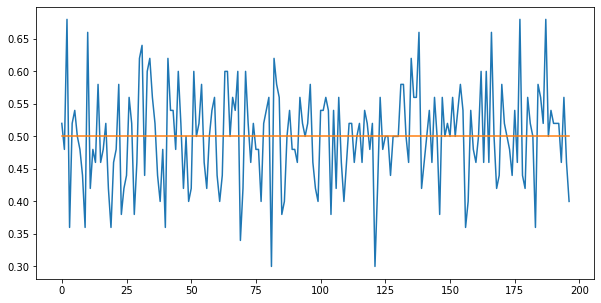

In [11]:
essay = """出师表   诸葛亮
先帝创业未半而中道崩殂，今天下三分，益州疲弊，此诚危急存亡之秋也。然侍卫之臣不懈于内，忠志之士忘身于外者，盖追先帝之殊遇，欲报之于陛下也。诚宜开张圣听，以光先帝遗德，恢弘志士之气，不宜妄自菲薄，引喻失义，以塞忠谏之路也。
宫中府中，俱为一体，陟罚臧否，不宜异同。若有作奸犯科及为忠善者，宜付有司论其刑赏，以昭陛下平明之理，不宜偏私，使内外异法也。
侍中、侍郎郭攸之、费祎、董允等，此皆良实，志虑忠纯，是以先帝简拔以遗陛下：愚以为宫中之事，事无大小，悉以咨之，然后施行，必能裨补阙漏，有所广益。
将军向宠，性行淑均，晓畅军事，试用于昔日，先帝称之曰“能”，是以众议举宠为督：愚以为营中之事，悉以咨之，必能使行阵和睦，优劣得所。
亲贤臣，远小人，此先汉所以兴隆也；亲小人，远贤臣，此后汉所以倾颓也。先帝在时，每与臣论此事，未尝不叹息痛恨于桓、灵也。侍中、尚书、长史、参军，此悉贞良死节之臣，愿陛下亲之信之，则汉室之隆，可计日而待也。
臣本布衣，躬耕于南阳，苟全性命于乱世，不求闻达于诸侯。先帝不以臣卑鄙，猥自枉屈，三顾臣于草庐之中，咨臣以当世之事，由是感激，遂许先帝以驱驰。后值倾覆，受任于败军之际，奉命于危难之间：尔来二十有一年矣。
先帝知臣谨慎，故临崩寄臣以大事也。受命以来，夙夜忧叹，恐托付不效，以伤先帝之明，故五月渡泸，深入不毛。今南方已定，兵甲已足，当奖率三军，北定中原，庶竭驽钝，攘除奸凶，兴复汉室，还于旧都。此臣所以报先帝而忠陛下之职分也。至于斟酌损益，进尽忠言，则攸之、祎、允之任也。
愿陛下托臣以讨贼兴复之效，不效，则治臣之罪，以告先帝之灵。若无兴德之言，则责攸之、祎、允等之慢，以彰其咎；陛下亦宜自谋，以咨诹善道，察纳雅言，深追先帝遗诏，臣不胜受恩感激。今当远离，临表涕零，不知所言。
"""

avoids = ["taactttaaataatgcgcattatttaaagtta".upper(), "ataacttcgtataatgtacattatacgaagttat".upper(), "ttgagagcagcggtagctgtagg".upper(), 
          "catgcttgcaaggcatccaaagg".upper(), "gtaaccatgatcgtccatggagg".upper(), "ctgtcatcatgtccagctcgagg".upper(), "accagtctaccatgccactgagg".upper(), "tgcaagcctatggaaggtcaagg".upper()]
haf = getHuffmanCode(essay)
haff = encode_huffman(essay, haf[1])
dhaf = decode_huffman(haf[0], haf[1].keys(), haf[1].values())
# print(haf[1])
# import pickle, sys
# ss = pickle.dumps(haf[1])
# print(type(ss))
# ss = bin(int.from_bytes(ss, byteorder=sys.byteorder))
seq = BitToDNA(haf[0])


# ecc=RSCodec(4)#纠错码字长度，可纠正n/2个误读
# #编码
# byte_msg=ecc.encode(seq.encode("utf-8")) #8个字符+6个纠错字=14字符=14*8位
# print(byte_msg)
# #转换为二进制
# binary_code=''.join(format(x,'08b') for x in byte_msg)
# print(len(binary_code),type(binary_code))
# print(binary_code)


import Functions.LowLevelAPI as lapi
result = []
for base in seq:
    result.append(base)
    if base == 'A':
        result.append('CG')
    elif base == 'T':
        result.append('GA')
    elif base == 'C':
        result.append('TGA')
    else:
        result.append('CTT')
seq = ''.join(result)


seq_random = generate_random_seq(3767397, len(seq))
ori_seq = seq
seq = seq_xor(seq, seq_random)
dec_seq = seq_xor(seq, seq_random)
# print(ori_seq, dec_seq)
print(len(seq), lapi.get_GC_content(seq), '\n'+seq)

for s in avoids:
    if s in seq:
        print("不行！")
        
import matplotlib.pyplot as plt

datay = []

num = len(seq) // 50
datax = [i for i in range(num)]
for i in range(num):
    s = seq[i*50: (i+1)*50]
    datay.append(lapi.get_GC_content(s))
plt.figure(figsize=(10, 5))
plt.plot(datax, datay)
plt.plot(datax, [lapi.get_GC_content(seq) for _ in range(num)])

plt.show()

## 游程编码解码，系数矩阵编码解码还原测试

In [24]:
ori = ArrayToBytes(dna.coeChannels.Ychannel[1][0].quantArray)
enc = RunLengthEncode(ori)
dec = RunLengthDecode(enc[1])
print(dec)
assert(ori == dec)

recoveryArray = BytesToArray(dec, 36, 20)
for i in range(36):
    for j in range(20):
        if dna.coeChannels.Ychannel[1][0].quantArray[i][j] == recoveryArray[i][j]:
            continue
        else:
            print("ERROR")
            break

#ArrayToBytes(dna.coeChannels.Ychannel[0].quantArray)

NameError: name 'dna' is not defined

In [693]:
data = ""
ori = ArrayToBytes(dna.coeChannels.Ychannel[0].quantArray)
enc = (ori)
data += enc

ori = ArrayToBytes(dna.coeChannels.Cbchannel[0].quantArray)
enc = (ori)
data += enc

ori = ArrayToBytes(dna.coeChannels.Crchannel[0].quantArray)
enc = (ori)
data += enc

for i in range(dna.level):
    for j in range(3):
        ori = ArrayToBytes(dna.coeChannels.Ychannel[i+1][j].quantArray)
        enc = RunLengthEncode(ori)
        data += enc[0]
        
        ori = ArrayToBytes(dna.coeChannels.Cbchannel[i+1][j].quantArray)
        enc = RunLengthEncode(ori)
        data += enc[0]
        
        ori = ArrayToBytes(dna.coeChannels.Crchannel[i+1][j].quantArray)
        enc = RunLengthEncode(ori)
        data += enc[0]
data

(36, 20)
(36, 20)
(36, 20)
(36, 20)
RunLength--原始比特长度：5760  编码后比特长度：3952  压缩率：0.3138888888888889
(36, 20)
RunLength--原始比特长度：5760  编码后比特长度：3664  压缩率：0.3638888888888889
(36, 20)
RunLength--原始比特长度：5760  编码后比特长度：3728  压缩率：0.3527777777777778
(36, 20)
RunLength--原始比特长度：5760  编码后比特长度：2720  压缩率：0.5277777777777778
(36, 20)
RunLength--原始比特长度：5760  编码后比特长度：2864  压缩率：0.5027777777777778
(36, 20)
RunLength--原始比特长度：5760  编码后比特长度：3024  压缩率：0.475
(36, 20)
RunLength--原始比特长度：5760  编码后比特长度：2240  压缩率：0.6111111111111112
(36, 20)
RunLength--原始比特长度：5760  编码后比特长度：2288  压缩率：0.6027777777777777
(36, 20)
RunLength--原始比特长度：5760  编码后比特长度：2224  压缩率：0.6138888888888889
(72, 40)
RunLength--原始比特长度：23040  编码后比特长度：5712  压缩率：0.7520833333333333
(72, 40)
RunLength--原始比特长度：23040  编码后比特长度：5488  压缩率：0.7618055555555555
(72, 40)
RunLength--原始比特长度：23040  编码后比特长度：5216  压缩率：0.7736111111111111
(72, 40)
RunLength--原始比特长度：23040  编码后比特长度：7120  压缩率：0.6909722222222222
(72, 40)
RunLength--原始比特长度：23040  编码后比特长度：7216  压缩率：0.6868055555555556
(

'\x80N`psli\x7fy\x88¢\xa0\xa0\x9e\x9f\xad£\x93\x98¡Z\x9c\x9d\x96{m\x8ctsp=\x9atiPd\x7f\x8f]\x82G\xadMN"\x10\x88`hY8zZnB>¨\xadj\x85\x8f\x9c^a\r\x1d\x86aaP9p[gDP®¢\x9e\x89=\x84no\x19\x1a\x85fNfu\x82_>bgâ¯\x8c\x80;\x9e\x878aVvxP;\'TcK@JÐ¥zq\x96e¼?6jt~jh\x91\x98\x81y|k°½Å·°¤³\x99\x8d|{q\x86\x84\x8e\x9d\x9d\x8cf_x¾ÐÂÊ\x8frpN<(\x8eGTA)\x13#/#fK\x8aÁJ\x0f\x0e$\x0e\x0c\x00ÅR.T4+IF;\x9dM\x835\x1e\x0b\n\x11)W8ÎZ;e`Zht\x8cÎf\x880&`\x8d\x8c\x81\x8a\x97ÿ\x80q\x86\x8b\x8c\x86\x87\x81\xa0T\x90&.\x87¶\x8fr\x88\x88\x9eqr|YWRJQ\x80¤\x83#+NGDDFRVjUbXO5FCO\x9d\x91(\'>MUQMWccdap\x97\x86\x88\x8c\x86\x91u\x1ef¤\x99\x8e\x90\x96\x8e\x8a\x8c\x8d\x90\x9c³\x88{xª\x82tKÀ\xa0\x93\x93\x9a\x96\x8b\x8d\x87\x80\x81\x85\xa0\x81\x9d\x8d¶©~ª¹\x8f\x8c\x92\x9a\x9a\x97\x9a\x99\x96\x99¨Ä£²º¼¼¡\x9d\x9c®¨¥¨\x9f\x98\x93\x94\x9a\x8c\x84Á´¥\x9e\x9e\x99\x96\x8f\x90¦¢¤¨§¥¦§¢\x98\x8d°\x95\x8a\x87\x83\x82\x84\x8d\x87§¡£§¦¤\xa0\x9f\x97\x96\x87ª\x91\x90\x86\x80\x7f\x80\x7f\x80£¦¥¥££\x9a\x99\x96\x89\x87®\x94\x81\x84\x84\x86\x85\x88¬¦\xad

In [707]:
haf = getHuffmanCode(data)
haf


Huffman--原始比特长度：3811744  编码后比特长度：2689606  压缩率：0.29438965470923545
Huffman--原始比特长度：3811744  编码后比特长度：2689606  压缩率：0.29438965470923545


## 游程＋哈夫曼编码还原矩阵测试

In [657]:
ori = ArrayToBytes(dna.coeChannels.Ychannel[1][0].quantArray)
enc = RunLengthEncode(ori)
haf = getHuffmanCode(enc[0])
dhaf = decode_huffman(haf[0], haf[1].keys(), haf[1].values())
dec = RunLengthDecode(dhaf[1])
print(dec)
assert(ori == dec)

#print(dhaf)

recoveryArray = BytesToArray(dec, 36, 20)
for i in range(36):
    for j in range(20):
        if dna.coeChannels.Ychannel[1][0].quantArray[i][j] == recoveryArray[i][j]:
            continue
        else:
            print("ERROR")
            break

(36, 20)
RunLength--原始比特长度：5760  编码后比特长度：3952  压缩率：0.3138888888888889
Huffman--原始比特长度：3952  编码后比特长度：2207  压缩率：0.4415485829959514
nnnnnn²­nnn%#n4KCnnnnLA7nnnnnnnnn0nnnn nnnnnnnnnnnnnnnnnnnnnnnnnnnn,nnnnÿãnùnG7nnnî°nn£nnnnCRnnnnnnI8nnnn;Pnnn¢nnnnn¦n nnnnnnnÐ¢nn´nnnnnn¥´¼»8nnnn5Gnnnn°)5nK9>nAnnnnnnn.MnBOnnnnnnnnnnK+Lnnnnnnn/RnnÆ²nnnnnnnnOnnnnn¶Ånn¤nOEnn­nnnnQLGLnnÇ®¢¡Pnnnnnnnnnn-G>D,.3nnnnnnn8nnnn nnnnnnnnnnONN­nnnnnnnnnnnnnHnnnn²nnnnnnnnnnMPnIOnnnnnn>nn ¾ÔÖÍÑnnnH>nnnnn-@nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnD:0HFEnnnn¸ÆÓÊÖn³²¤nnnnnnnnnnnnnnnnnnnnnnnnnnnHnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnP;nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnM6;<3n)F2#24@>nÈÚæãØÉ«nnnnnnnnnJGKnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnJnRnnnnnnnnnnnnnnnnnnn­nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


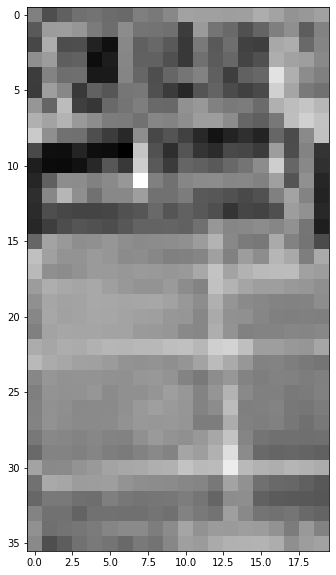

In [490]:
plt.figure(figsize=(20,10)) 
plt.imshow(dna.coeChannels.Ychannel[0].quantArray, cmap="gray")

# 二进制阶段全流程演示，包括读取图像 设置小波变换级数 编码小波级数 缩放因子设置 图像预览 成本显示

(1280, 1706, 3)
Y: (20, 27)
Y: (20, 27)
Y: (20, 27)
Y: (40, 54)
Y: (40, 54)
Y: (40, 54)
Y: (80, 107)
Y: (80, 107)
Y: (80, 107)
Y: (160, 214)
Y: (160, 214)
Y: (160, 214)
Y: (320, 427)
Y: (320, 427)
Y: (320, 427)
Y: (640, 853)
Y: (640, 853)
Y: (640, 853)
Cb: (20, 27)
Cb: (20, 27)
Cb: (20, 27)
Cb: (40, 54)
Cb: (40, 54)
Cb: (40, 54)
Cb: (80, 107)
Cb: (80, 107)
Cb: (80, 107)
Cb: (160, 214)
Cb: (160, 214)
Cb: (160, 214)
Cb: (320, 427)
Cb: (320, 427)
Cb: (320, 427)
Cb: (640, 853)
Cb: (640, 853)
Cb: (640, 853)
Cr: (20, 27)
Cr: (20, 27)
Cr: (20, 27)
Cr: (40, 54)
Cr: (40, 54)
Cr: (40, 54)
Cr: (80, 107)
Cr: (80, 107)
Cr: (80, 107)
Cr: (160, 214)
Cr: (160, 214)
Cr: (160, 214)
Cr: (320, 427)
Cr: (320, 427)
Cr: (320, 427)
Cr: (640, 853)
Cr: (640, 853)
Cr: (640, 853)
(20, 27)
(20, 27)
(20, 27)
(20, 27)
RunLength--原始比特长度：4320  编码后比特长度：4032  压缩率：0.06666666666666667
(20, 27)
RunLength--原始比特长度：4320  编码后比特长度：4832  压缩率：-0.11851851851851852
(20, 27)
RunLength--原始比特长度：4320  编码后比特长度：4544  压缩率：-0.0518518518518

/home/zsf/lib/python3.7/site-packages/ipykernel_launcher.py:300: RuntimeWarning: invalid value encountered in true_divide


采用哈夫曼算法解码
1 1
采用游程+哈夫曼算法解码
1 2
采用游程+哈夫曼算法解码
1 2
发现有效bit为奇数，已经自动丢弃最后一个bit，有效bit长度：2759
采用游程+哈夫曼算法解码
1 2
采用游程+哈夫曼算法解码
1 3
发现有效bit为奇数，已经自动丢弃最后一个bit，有效bit长度：2003
采用游程+哈夫曼算法解码
1 3
采用游程+哈夫曼算法解码
1 3
采用游程+哈夫曼算法解码
2 1
发现有效bit为奇数，已经自动丢弃最后一个bit，有效bit长度：5197
采用游程+哈夫曼算法解码
2 1
发现有效bit为奇数，已经自动丢弃最后一个bit，有效bit长度：4491
采用游程+哈夫曼算法解码
2 1
采用游程+哈夫曼算法解码
2 2
发现有效bit为奇数，已经自动丢弃最后一个bit，有效bit长度：4995
采用游程+哈夫曼算法解码
2 2
发现有效bit为奇数，已经自动丢弃最后一个bit，有效bit长度：5535
采用游程+哈夫曼算法解码
2 2
发现有效bit为奇数，已经自动丢弃最后一个bit，有效bit长度：1441
采用游程+哈夫曼算法解码
2 3
采用游程+哈夫曼算法解码
2 3
采用游程+哈夫曼算法解码
2 3
467.6862745098039 509.7294117647061 683.4196078431373
8176.790196078433 8167.619607843138 8170.523529411766
-127.82058823529391 -23.26862745098032 37.765686274510074
4091.132352941178 4089.2019607843145 4088.2598039215695


<Figure size 2880x1440 with 0 Axes>

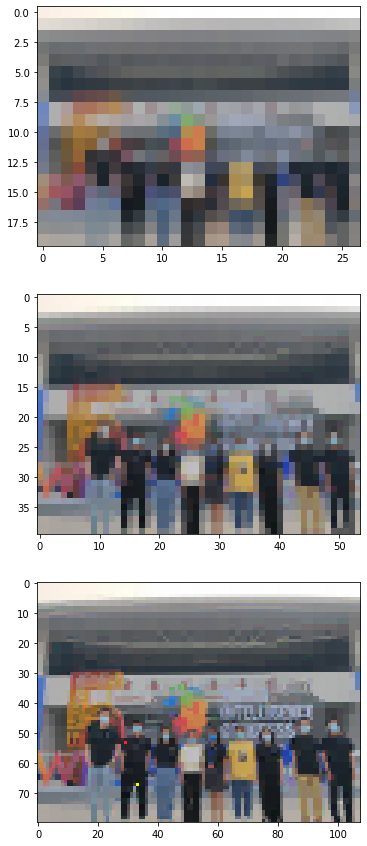

In [61]:
dna = DNAImage(Image.open("images/wic.jpg"))
t = dna.DWT(6, isGrayImg=False)


# for i in range(4):
#     for j in range(3):
#         tt = t.coeChannels.Ychannel[i+1][j].quantArray
#         mid = abs(tt.mean())
#         a = tt < tt.max() / (100)
#         b = tt > tt.min() / (100)
#         tt[a & b] = mid
#         t.coeChannels.Ychannel[i+1][j].quantArray = tt




enc = t.coeChannels.encode(2, factor=6)
imgs = Decoder_CoeDataFrame().Decode(enc, dna.coeChannels.huf_dict, isGrayImg=False).coeChannels.AssembleAndCalulateIDWT_2levels(0)
plt.figure(figsize=(40,20)) 
f, ax = plt.subplots(len(imgs), 1, figsize=(40, 15))
for i in range(len(imgs)):
    ax[i].imshow(imgs[i], cmap='gray', interpolation='nearest')
    

# 生成摘要文件及原始文件DNA序列，显示最终成本

In [1]:
total_bp = 0
total_seq_num_preview = 0
total_seq_num_other = 0
el = DNAFrameGroup()
eh = DNAFrameGroup()
DNAFrameGroup_L = []
DNAFrameGroup_H = []
for bitStream in enc[:3]:  # 编码摘要文件（低频分量）三通道序列

    el = el.CreateEncoder(bitStream, fps[0], fps[1], rps[1], rps[0], 1, True, 'AAAAATTTTTGGGGGCCCCCTTTTTAAAAA')
    DNAFrameGroup_L.append(el)
    total_seq_num_preview += len(el.dna_seq_group)
    for c in el.dna_seq_group:
        total_bp += len(c)
for bitStream in enc[3:]:  # 编码原始文件（高频分量）三通道序列

    eh = eh.CreateEncoder(bitStream, fps[0], fps[1], rps[1], rps[0], 1, False, 'AAAAATTTTTGGGGGCCCCCTTTTTAAAAA')
    DNAFrameGroup_H.append(eh)
    total_seq_num_other += len(eh.dna_seq_group)
    for c in eh.dna_seq_group:
        total_bp += len(c)
print("********************[最终成本结算]********************")
print("DNA条数总计：", total_seq_num_preview + total_seq_num_other, "条")
print("DNA序列合成成本：", total_bp // 2, "元")
print("[摘要文件]条数总计：", total_seq_num_preview, "条")
print("[摘要文件]预估不分析测序费用（测序深度100x计算PE250）：", total_seq_num_preview * 100 / 250, "元")
print("PE250测序 不足200元按照200元计费")
print("[原始文件(包括摘要文件)]条数总计：", total_seq_num_preview + total_seq_num_other, "条")
print("[原始文件(包括摘要文件)]预估不分析测序费用（测序深度100x计算PE250）：", (total_seq_num_preview + total_seq_num_other) * 100 / 250, "元")
print("PE250测序 不足200元按照200元计费")
print("总测序费用（一次摘要一次原始访问）：", total_seq_num_preview * 100 / 250 + (total_seq_num_preview + total_seq_num_other) * 100 / 250, '元', "!!不足400按400计算")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


NameError: name 'DNAFrameGroup' is not defined

In [1818]:
for e in DNAFrameGroup_L:
    strand.check_max_2seqs_complement_hybird(fps[0],strand.get_complement_strand(e.dna_seq_group[0])[:-100] )


  CCGCCACGTAATATGTCACT
      | ||| || |||   |
ATACTTGCGCACTAAACAAACAACGAAATAAACAAACAAAGCTATTCGGAGTCAAACAAACAAACAAACAAACAAACAAACAAACAAACCTATTCACGATAGACCTACTTGTAGTTTTGTAGCTCCTGAGCTATAGCAAGCAAAGAAACAAACACCCTGCTGGGTGTATGTGGGCACGAGAGTACGACCGGCTTACTGGCGTGCTCGGGAAACAAACAAACGAAGTCGCGCTTTCCGTCAATTGGTTTATTTGTTTTTGATTAACTCCCGCATTCCAAAATAAACAAGGTGATGAGCTTGCTTTTGGGAGCAAACCATTATGTTCCGATGAGTAGACGTTCTCTCAGCCTAATATGCACTGGAGCCCTGTCCCAGTCATT
  CCGCCACGTAATATGTCACT
      | ||| || |||   |
ATACTTGCGCACTAAACAAACAACGAAATAAACAAACAAAGCTATTCGGAGTCAAACAAACAAACAAACAAACAAACAAACAAACAAACCTATTCACGATAGACCTACTTGTAGTTTTGTAGCTCCTGAGCTATAGCAAGCAAAGAAACAAACACCCTGCTGGGTGTATGTGGGCACGAGAGTACGACCGGCTTACTGGCGTGCTCGGGAAACAAACAAACGAAGTCGCGCTTTCCGTCAATTGGTTTATTTGTTTTTGATTAACTCCCGCATTCCAAAATAAACAAGGTGATGAGCTTGCTTTTGGGAGCAAACCATTATGTTCCGATGAGTAGACGTTCTCTCAGCCTAATATGCACTGGAGCCCTGTCCCAGTCATT
  CCGCCACGTAATATGTCACT
      | ||| || |||   |
ATACTTGCGCACTAAACAAACAACGAAATAAACAAACAAAGCTATTCGGAGTCAAACAAACAAACAAACAAACAAACAAACAAACAAACCTATTCACGAT